# Agent Based Staircase Model

## This notebook implements an agent-based approach to modeling the travel of people up and down a staircase simultaneously. 

Each agent has the following characteristics:
- Age (years)
- Sex (M/F)
- Height (cm)
- Weight (kg)
- Group
- Stepping Pattern (traditional: one footstep per stair, double: two footsteps per stair, skip: only step on every other stair)
    - Sampled from a distribution dependent on the age, height, and weight of the agent
- Intended Final Destination
- Desired Velocity $v$ (m/s)
- Ascending/Descending

The following parameters are used to define the staircase domain:
- The number of stairs $N$
- The length of each step ${l}_{i = 1}^N $
- The width of each step ${w}_{i=1}^N $

It is assumed that the steps are continuous in that the length of the far edge must align with the length of the close edge of the next step and vice versa.

Groups arrive at the staircase according to a Poisson Arrival Process. When a group arrives, the size of the group is sampled from a distribution and each of the members of the group are introduced into the model. 

The initial locations of the agents within the staircase are found by first introducing them in a horizonal arrangement (i.e. shoulder-to-shoulder) in an open space before the staircase subject to the same attracion and repulsions which govern movement within the staircase. This open space then narrows to match the dimensions of the fist stair, serving as a funnel. This enables the groups to form an inital arrangement on the staircase which resembles a natural group walking formation.

Attractive Forces:
- Desire to reach intended destination atop the staircase by following a linear trajectory (most efficient route between points a and b is a straight line)
- Desire to maintain intended velocity
- Desire to maintain a certain distance between group members
- Desire to obey agreed upon social convention (walking on the right side vs left side)

Repulsive Forces:
- Desire not to get too close to other people 
    - the strength of this desire depends on whether the other agent is a member of one's group and the direction in which they are traversing (e.g. One would have a stronger desire to avoid contact with someone going in the opposite direction)

These attractive and repulsive forces are then combined into a utility function which determines where the agent will step on the next stair in the $x$ dimension (along the width of the stair). 

The final output of this model is a dataset of simulated steps on each stair and their associated agent. These steps can easily be converted to represent the cumulative pressure placed on each stair over the time interval in which the simulation is run. With a long enough sample, we can then extrapolate to a larger time interval by assuming periodicity in the stepping patterns. 


In [46]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math
import random 

## Agent Class

In [18]:
class Agent:
    def __init__(self, unique_id, age, sex, height, weight, desired_velocity, direction, group_id, position, destination):
        self.unique_id = unique_id
        self.age = age
        self.sex = sex
        self.height = height
        self.weight = weight
        self.velocity = desired_velocity
        self.direction = direction
        self.group_id = group_id
        self.current_position = position # (x, y, stair_index)
        self.next_position = position # both feet together at instantiation
        self.foot_length = 0.15 * self.height
        self.foot_width = 0.4 * self.foot_length
        self.active = True
        self.desired_step_radius = 0.4 * height
        self.max_step_radius = 1.5 * self.max_step_radius
        self.destination = destination # (x,y,z) coordinates, no stair_index 
        self.time_steps_to_update = 0

    
    def sample_candidates(self, staircase):
        """
        Generates a list of possible positions for the agent's next step.

        Args:
            staircase (Staircase): The staircase object.

        Returns:
            list: A list of valid candidate positions (x, y, z, velocity).
        """
        candidates = []
        max_stride = self.stride_length  # Maximum stride length for the agent
        current_x, current_y, current_z = self.current_position

        for _ in range(200):  # Generate 200 random candidate positions
            # Sample random displacements
            dx = np.random.uniform(-max_stride, max_stride)
            dy = np.random.uniform(0, max_stride)  # Forward motion preferred (positive y-direction)
            dz = np.random.choice([0, 1] if self.direction == "ascending" else [0, -1])  # Ascend, descend, or stay

            # Convert dz to height displacement
            current_stair_idx = self.current_position[2]
            next_stair_idx = current_stair_idx + dz
            current_height = staircase.stairs[current_stair_idx].z
            next_height = staircase.stairs[next_stair_idx].z

            dz_height = math.abs(current_height - next_height)

            # Check 3D Euclidean stride length
            if np.sqrt(dx**2 + dy**2 + dz_height**2) > max_stride:
                continue

            # Calculate candidate position
            candidate_x = current_x + dx
            candidate_y = current_y + dy
            candidate_z = current_z + dz # this is the stair index!!, not the actual z

            # Validate position on the staircase
            if not (0 <= candidate_z < staircase.num_stairs and self._is_within_stair_width(candidate_x, candidate_y, candidate_z, staircase)):
                continue

            # Check foot placement validity
            if not self._is_valid_foot_placement(candidate_x, candidate_y, candidate_z, staircase):
                continue

            # Add candidate to the list
            candidates.append((candidate_x, candidate_y, candidate_z, self.velocity))

        return candidates


    def _is_within_stair_width(self, x, y, z, staircase):
        """
        Checks if a candidate position is within the stair's width and depth.

        Args:
            x (float): X-coordinate of the candidate position.
            y (float): Y-coordinate of the candidate position.
            z (int): Stair index of the candidate position.
            staircase (Staircase): The staircase object.

        Returns:
            bool: True if the position is within the stair bounds, False otherwise.
        """
        half_width = staircase.step_widths[z] / 2
        depth_start = sum(staircase.step_depths[:z])
        depth_end = depth_start + staircase.step_depths[z]
        return (-half_width <= x <= half_width) and (depth_start <= y <= depth_end)

    def _is_valid_foot_placement(self, x, y, z, staircase):
        """
        Ensures that the foot placement doesn't intersect the back of the stair.

        Args:
            x (float): X-coordinate of the candidate position.
            y (float): Y-coordinate of the candidate position.
            z (int): Stair index of the candidate position.
            staircase (Staircase): The staircase object.

        Returns:
            bool: True if the foot placement is valid, False otherwise.
        """
        if z == 0:  # First stair has no previous stair
            return True

        # Calculate the back of the previous stair
        prev_depth_end = sum(staircase.step_depths[:z])
        foot_end_y = y + self.foot_length / 2

        # Ensure the end of the foot doesn't intersect the back of the previous stair
        return foot_end_y <= prev_depth_end
        


    def update_position(self, utility_function, agents, staircase):
        """
        Updates the agent's position and velocity based on the utility function. 
        When the front foot is placed:
          next_position becomes current position
          the current position is added to the list for the stair that it falls on
          the placement of the other foot is decided upon (next_position) based on the previous position of that foot

        Args:
            utility_function (callable): The utility function to evaluate candidates.
            agents (list): List of all agents.
            staircase (Staircase): The staircase object.
        """
        if not self.active:
            return

        # Sample candidates for the agent's next position
        candidates = self.sample_candidates(self, staircase)

        # Find the best candidate based on utility
        best_utility = float('-inf')
        best_candidate = None
        for candidate in candidates:
            # Call the utility function with all required arguments
            candidate_with_z = candidate
            candidate_with_z[2] = staircase.stairs[candidate[2]].z
            utility = utility_function(self, agents, staircase, candidate_with_z, self.social_convention, self.propensity_to_follow)
            if utility > best_utility:
                best_utility = utility
                best_candidate = candidate

        temp_position = self.next_position # needed for 3 way swap 

        # Update position and velocity based on the best candidate
        if best_candidate:
            self.next_position = (best_candidate[0], best_candidate[1], best_candidate[2])  # (x,y, stair_index)
            self.velocity = best_candidate[3]

        previous_position = self.current_position

        self.current_position = temp_position # This is the step!
        staircase.stairs[self.current_position[2]].add_step(self.current_position[0], self.current_position[1], self) # add the step to that stair so we have it on our heat map later

        # Replace stair index with the actual z value for next_position and previous_position
        next_position_with_z = (
            self.next_position[0],
            self.next_position[1],
            staircase.stairs[self.next_position[2]].z
        )
        previous_position_with_z = (
            previous_position[0],
            previous_position[1],
            staircase.stairs[previous_position[2]].z
        )

        # Compute the time steps to update
        self.time_steps_to_update = round(
            10 * np.linalg.norm(np.array(previous_position_with_z) - np.array(next_position_with_z)) / self.velocity
        )
       

        # Check if the agent has reached the destination
        if self.current_position[2] >= staircase.num_stairs and self.direction == "ascending" or self.current_position[2] <= 0 and self.direction == "descending":
            self.active = False

        

## Group Class

In [48]:
class Group:
    def __init__(self, group_id, bottom_funnel_vertices, top_funnel_vertices, direction, num_stairs):
        """
        Initialize a Group.

        Parameters:
        - group_id: Unique identifier for the group.
        - bottom_funnel_vertices: The four vertices of the bottom funnel (bottom left, bottom right, top right, top left).
        - top_funnel_vertices: The four vertices of the top funnel (bottom left, bottom right, top right, top left).
        - direction: "ascending" or "descending".
        - num_stairs: The number of stairs on the staircase (doesn't include the top funnel so we add 1 to stair_idx).
        """
        self.group_id = group_id
        self.bottom_funnel_vertices = bottom_funnel_vertices
        self.top_funnel_vertices = top_funnel_vertices
        self.direction = direction

        # Sample group size from a right-skewed distribution (e.g., exponential distribution).
        self.group_size = max(1, int(np.random.exponential(scale=1.5)))  # Ensures at least 1 agent
        self.agents = []

        # Set destination and initial y-position based on direction.
        if direction == "ascending":
            destination = np.mean(top_funnel_vertices, axis=0)  # Average position of top funnel vertices
            stair_idx = 0
            y_position = bottom_funnel_vertices[0][1]  # Bottom funnel y-coordinate
        else:
            destination = np.mean(bottom_funnel_vertices, axis=0)  # Average position of bottom funnel vertices
            stair_idx = num_stairs + 1
            y_position = top_funnel_vertices[3][1]  # Top funnel y-coordinate

        # Assign a uniform velocity for the group.
        group_velocity = np.random.uniform(0.5, 1.5)  # Random velocity in m/s

        # Instantiate agents.
        for i in range(self.group_size):
            unique_id = f"Group{group_id}_Agent{i}"
            x_position = i  # Space agents by 1 meter starting from x = 0

            # Sample attributes for the agent.
            age = np.random.randint(10, 70)  # Age between 10 and 70
            sex = np.random.choice(["M", "F"])
            height = np.random.normal(1.7, 0.1)  # Average height: 1.7 meters, std dev: 0.1 meters
            weight = np.random.normal(70, 15)  # Average weight: 70 kg, std dev: 15 kg

            # Create an Agent and set its initial position.
            position = (x_position, y_position, stair_idx)
            agent = Agent(
                unique_id, age, sex, height, weight, group_velocity, direction,
                group_id, position, destination
            )

            self.agents.append(agent)


## Staircase Class

Staircase Domain with Funnels on Each End

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


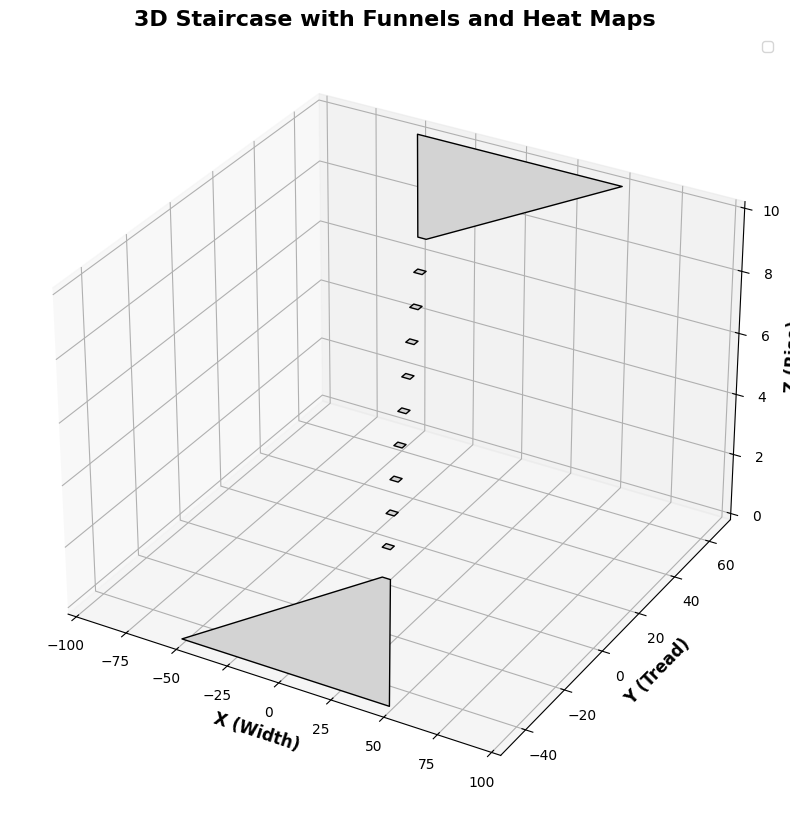

Stair 1:
  [-50.0, -50, 0]
  [50.0, -50, 0]
  [2.0, 0, 0]
  [-2.0, 0, 0]
Stair 2:
  [-2.0, 0, 1]
  [2.0, 0, 1]
  [2.0, 2, 1]
  [-2.0, 2, 1]
Stair 3:
  [-2.0, 2, 2]
  [2.0, 2, 2]
  [2.0, 4, 2]
  [-2.0, 4, 2]
Stair 4:
  [-2.0, 4, 3]
  [2.0, 4, 3]
  [2.0, 6, 3]
  [-2.0, 6, 3]
Stair 5:
  [-2.0, 6, 4]
  [2.0, 6, 4]
  [2.0, 8, 4]
  [-2.0, 8, 4]
Stair 6:
  [-2.0, 8, 5]
  [2.0, 8, 5]
  [2.0, 10, 5]
  [-2.0, 10, 5]
Stair 7:
  [-2.0, 10, 6]
  [2.0, 10, 6]
  [2.0, 12, 6]
  [-2.0, 12, 6]
Stair 8:
  [-2.0, 12, 7]
  [2.0, 12, 7]
  [2.0, 14, 7]
  [-2.0, 14, 7]
Stair 9:
  [-2.0, 14, 8]
  [2.0, 14, 8]
  [2.0, 16, 8]
  [-2.0, 16, 8]
Stair 10:
  [-2.0, 16, 9]
  [2.0, 16, 9]
  [2.0, 18, 9]
  [-2.0, 18, 9]
Stair 11:
  [-2.0, 18, 10]
  [2.0, 18, 10]
  [50.0, 68, 10]
  [-50.0, 68, 10]


In [44]:
class Staircase:
    def __init__(self, num_stairs, step_widths, step_depths, step_heights, funnel_length, funnel_width_start, funnel_width_end):
        """
        Initializes a staircase with aligned funnels and configurable steps.

        Args:
            num_stairs (int): Number of intermediary steps in the staircase
            step_widths (list): List of widths for each step.
            step_depths (list): List of depths (tread) for each step.
            step_heights (list): List of heights (rise) for each step.
            funnel_length (float): Length of both the top and bottom funnels.
            funnel_width_start (float): Width of the bottom funnel.
            funnel_width_end (float): Width of the top funnel.
        """
        self.num_stairs = num_stairs
        self.step_widths = step_widths
        self.step_depths = step_depths
        self.step_heights = step_heights
        self.funnel_length = funnel_length
        self.funnel_width_start = funnel_width_start
        self.funnel_width_end = funnel_width_end

        # Validate input lengths
        if not (len(step_widths) == len(step_depths) == len(step_heights) == num_stairs):
            raise ValueError("step_widths, step_depths, and step_heights must have the same length as num_stairs.")

        # Compute all step and funnel vertices and create Stair objects
        self.stairs = []
        self._compute_all_vertices()

    def _compute_all_vertices(self):
        """
        Computes the vertices for all steps and funnels and stores them as Stair objects.
        """
        # Bottom funnel
        bottom_funnel_vertices = [
            [-self.funnel_width_start / 2, -self.funnel_length, 0],
            [self.funnel_width_start / 2, -self.funnel_length, 0],
            [self.step_widths[0] / 2, 0, 0],
            [-self.step_widths[0] / 2, 0, 0],
        ]
        self.stairs.append(Stair(bottom_funnel_vertices))

        # Steps
        current_z = self.step_heights[0]
        current_y = 0
        for i in range(self.num_stairs - 1):
            step_vertices = [
                [-self.step_widths[i] / 2, current_y, current_z],
                [self.step_widths[i] / 2, current_y, current_z],
                [self.step_widths[i] / 2, current_y + self.step_depths[i], current_z],
                [-self.step_widths[i] / 2, current_y + self.step_depths[i], current_z],
            ]
            self.stairs.append(Stair(step_vertices))
            current_z += self.step_heights[i+1]
            current_y += self.step_depths[i]

        # Top funnel
        top_funnel_vertices = [
            [-self.step_widths[-1] / 2, current_y, current_z],
            [self.step_widths[-1] / 2, current_y, current_z],
            [self.funnel_width_end / 2, current_y + self.funnel_length, current_z],
            [-self.funnel_width_end / 2, current_y + self.funnel_length, current_z],
        ]
        self.stairs.append(Stair(top_funnel_vertices))
    
    def print_vertices(self):
        """
        Prints the vertices of each stair, including the funnels.
        """
        for i, stair in enumerate(self.stairs):
            print(f"Stair {i + 1}:")
            for vertex in stair.vertices:
                print(f"  {vertex}")

    def draw(self):
        """
        Draws the staircase including steps, funnels, and superimposed heat maps of the steps.
        """
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Draw stairs and funnels
        for stair in self.stairs:
            vertices = np.array(stair.vertices)
            x = vertices[:, 0]
            y = vertices[:, 1]
            z = vertices[:, 2]
            poly = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(poly, facecolors='lightgray', edgecolors='black'))

        # Plot heat maps for steps
        for stair in self.stairs:
            ascending_steps = [(step["x"], step["y"], step["z"]) for step in stair.steps if step["agent"].direction == "ascending"]
            descending_steps = [(step["x"], step["y"], step["z"]) for step in stair.steps if step["agent"].direction == "descending"]

            if ascending_steps:
                asc_x, asc_y, asc_z = zip(*ascending_steps)
                ax.scatter(asc_x, asc_y, asc_z, c="blue", alpha=0.7, label="Ascending Steps")

            if descending_steps:
                desc_x, desc_y, desc_z = zip(*descending_steps)
                ax.scatter(desc_x, desc_y, desc_z, c="red", alpha=0.7, label="Descending Steps")

        # Set axis limits and labels
        ax.set_xlim(-self.funnel_width_start, self.funnel_width_start)
        ax.set_ylim(-self.funnel_length, self.funnel_length + sum(self.step_depths))
        ax.set_zlim(0, sum(self.step_heights))
        ax.set_xlabel("X (Width)", fontsize=12, fontweight="bold")
        ax.set_ylabel("Y (Tread)", fontsize=12, fontweight="bold")
        ax.set_zlabel("Z (Rise)", fontsize=12, fontweight="bold")
        ax.set_title("3D Staircase with Funnels and Heat Maps", fontsize=16, fontweight="bold")
        ax.legend()
        plt.show()


# Example usage
staircase_with_funnels_aligned = Staircase(
    num_stairs=10,         # Number of intermediary steps
    step_widths=[4] * 10,  # Width of each step
    step_depths=[2] * 10,  # Depth of each step
    step_heights=[1] * 10, # Height of each step
    funnel_length=50,      # Length of the funnels
    funnel_width_start=100,# Width of the bottom funnel
    funnel_width_end=100   # Width of the top funnel
)

staircase_with_funnels_aligned.draw()
staircase_with_funnels_aligned.print_vertices()


## Stair Class

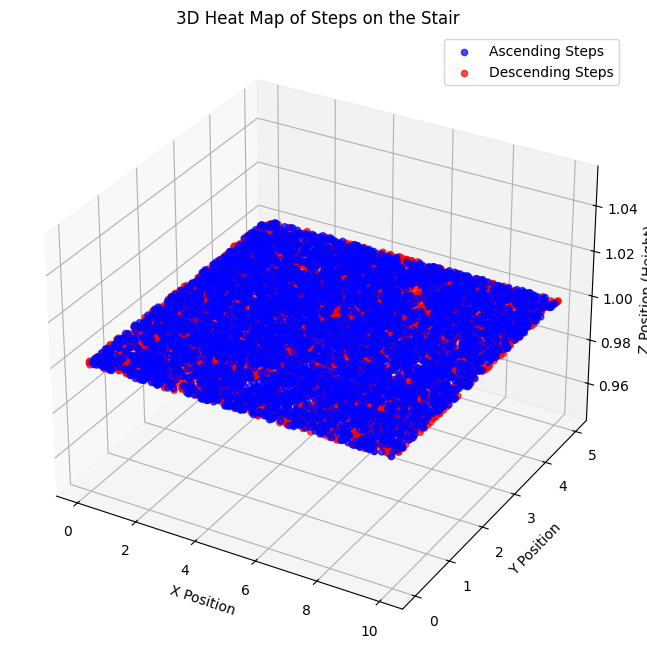

In [47]:
class Stair:
    def __init__(self, vertices):
        """
        Represents a single stair step or funnel.

        Args:
            vertices (list): List of (x, y, z) coordinates defining the vertices of the stair.
        """
        self.vertices = vertices  # Coordinates of the stair vertices (x, y, z)
        self.z = vertices[0][2]  # All vertices share the same Z-coordinate (flat surface)
        self.steps = []  # List to store steps (x, y, z, Agent)

    def add_step(self, x, y, agent):
        """
        Add a step to the list of steps. The Z-coordinate is automatically set to the stair's Z-level.

        Args:
            x (float): X-coordinate of the step.
            y (float): Y-coordinate of the step.
            agent (Agent): The Agent object that made the step.
        """
        self.steps.append({"x": x, "y": y, "z": self.z, "agent": agent})

    def plot_heat_map(self):
        """
        Plot a heat map of the steps on the stair, differentiating between ascending and descending steps.
        """
        # Separate ascending and descending steps
        ascending_steps = [(step['x'], step['y'], step['z']) for step in self.steps if step['agent'].direction == 'ascending']
        descending_steps = [(step['x'], step['y'], step['z']) for step in self.steps if step['agent'].direction == 'descending']

        # Create scatter plot data
        if ascending_steps:
            asc_x, asc_y, asc_z = zip(*ascending_steps)
        else:
            asc_x, asc_y, asc_z = [], [], []

        if descending_steps:
            desc_x, desc_y, desc_z = zip(*descending_steps)
        else:
            desc_x, desc_y, desc_z = [], [], []

        # Create the heat map
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        ax.scatter(asc_x, asc_y, asc_z, c='blue', label='Ascending Steps', alpha=0.7)
        ax.scatter(desc_x, desc_y, desc_z, c='red', label='Descending Steps', alpha=0.7)

        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_zlabel('Z Position (Height)')
        ax.set_title('3D Heat Map of Steps on the Stair')
        ax.legend()
        plt.show()


# Example usage
if __name__ == "__main__":
    # Define vertices for a single stair with a flat Z-coordinate
    vertices = [
        (0, 0, 1),  # All vertices have the same Z-coordinate
        (10, 0, 1),
        (10, 5, 1),
        (0, 5, 1)
    ]

    # Create a stair object
    stair = Stair(vertices=vertices)

    # Define an example Agent class (placeholder for the real Agent class)
    class AgentDummy:
        def __init__(self, unique_id, direction):
            self.unique_id = unique_id
            self.direction = direction

    # Create agents
    agents = [AgentDummy(unique_id=i, direction='ascending' if i % 2 == 0 else 'descending') for i in range(1000)]

    # Simulate steps
    np.random.seed(42)
    for agent in agents:
        for _ in range(np.random.randint(5, 15)):
            x = np.random.uniform(0, 10)
            y = np.random.uniform(0, 5)
            stair.add_step(x, y, agent)

    # Plot the heat map
    stair.plot_heat_map()


## Simulation Class

In [ ]:
class Simulation:
    def __init__(self, staircase_params, lambda_rate, simulation_duration, propensity_to_follow, group_size_distribution, prob_ascedning):
        self.staircase = Staircase(**staircase_params)
        self.lambda_rate = lambda_rate
        self.simulation_duration = simulation_duration
        self.propensity_to_follow = propensity_to_follow
        self.group_size_distribution = group_size_distribution
        self.prob_ascending = prob_ascedning
        self.time = 0
        self.agents = []
        self.arrival_times = self.generate_poisson_arrivals(lambda_rate, simulation_duration)

    @staticmethod
    def generate_poisson_arrivals(rate, duration):
        # Simulates a Poisson arrival process, returning a set of group arrival times
        arrivals = []
        current_time = 0

        while current_time < duration:
            # Generate interarrival time
            interarrival_time = np.random.exponential(1 / rate)
            current_time += interarrival_time
            if current_time < duration:
                arrivals.append(current_time)

        return arrivals


    def simulate(self):

        group_id = 0

        active_agents = [] # agents currently on the staircase or beginning funnel

        while self.time < self.simulation_duration:
            
            # Introduce groups according to the arrival times
            if len(self.arrival_times) > 0 and self.time >= self.arrival_times[0]:
                self.arrival_times = self.arrival_times[1:]  # Remove the first arrival time

                # decide whether direction is "ascending" or "descending" using self.prob_ascending which ranges from 0 to 1
                direction = "ascending" if random.random() < self.prob_ascending else "descending"

                bottom_funnel_vertices = self.staircase.stairs[0].vertices
                top_funnel_vertices = self.staircase.stairs[-1].vertices

                group = Group(group_id, bottom_funnel_vertices, top_funnel_vertices, direction)
                self.agents.extend(group.agents)
                group_id += 1

            # Iterate only through active agents
            for agent in active_agents[:]:  # Use slicing to safely modify the list during iteration

                # we only should update the agent if it just placed its foot
                if agent.active:

                    if agent.time_steps_to_update == 0:
                        agent.update_position(
                            self.utility_function,
                            active_agents,
                            self.staircase
                        )
                    else:
                        agent.time_steps_to_update -= 1

                if not agent.active:
                    # Remove inactive agents directly
                    active_agents.remove(agent)

            self.time += 1

    @staticmethod
    def utility_function(agent, agents, staircase, candidate, social_convention, propensity_to_follow):
        """
        Evaluates the utility of a candidate position and velocity for an agent.

        Args:
            agent (Agent): The current agent.
            agents (list): List of all agents in the simulation.
            staircase (Staircase): The staircase object.
            candidate (tuple): Candidate position and velocity (x, y, z, v).
            social_convention (str): The social convention ('left', 'right', or 'none').
            propensity_to_follow (float): The likelihood agents follow the convention (0 to 1).

        Returns:
            float: The utility value for the candidate.
        """
        # Step radius penalty constants
        beta_radius = 0.5  # Weight for step radius penalty

        x_c, y_c, z_c, v_c = candidate  # Candidate position and velocity

        # Progress term: movement toward destination with preferred velocity
        destination = agent.destination  # Assumed straight-line destination
        u_progress = -np.linalg.norm([x_c - destination[0], y_c - destination[1], z_c - destination[2]])**2
        u_progress -= (v_c - agent.velocity)**2

        # Comfort term: includes collision avoidance, group cohesion, boundary effects, step radius, and social convention
        u_avoid = 0
        for other_agent in agents:
            if other_agent != agent:
                dist_future = (
                    np.linalg.norm([x_c - other_agent.position[1], y_c - other_agent.position[2], z_c - other_agent.position[3]])
                    - (v_c + other_agent.velocity) * 0.5 * agent.delta_t
                )
                if dist_future < 0.5:  # Hard collision constraint
                    return float('-inf')
                else:
                    u_avoid -= agent.beta_collide * np.exp(-agent.gamma_collide * dist_future)

        # Group cohesion term
        u_group = sum(
            agent.beta_group * np.exp(-agent.gamma_group * np.linalg.norm([x_c - a.position[1], y_c - a.position[2], z_c - a.position[3]]))
            for a in agents if a.group_id == agent.group_id and a != agent
        )

        # Boundary effects
        staircase_width = staircase.step_widths[agent.position[0]]  # Width of the current stair
        dist_to_edge = min(abs(x_c), abs(staircase_width - x_c))
        u_boundary = -agent.beta_bound * np.exp(-agent.gamma_bound * dist_to_edge)

        # Step radius penalty
        current_position = np.array([agent.position[1], agent.position[2], agent.position[3]])
        candidate_position = np.array([x_c, y_c, z_c])
        step_distance = np.linalg.norm(candidate_position - current_position)
        delta = abs(step_distance - agent.desired_step_radius)
        u_step_radius = -beta_radius * delta**2

        # Social convention term
        if social_convention != "none":
            if social_convention == "left":
                convention_side = -staircase_width / 4  # Encourage positions to the left side
            elif social_convention == "right":
                convention_side = staircase_width / 4  # Encourage positions to the right side
            
            deviation_from_convention = abs(y_c - convention_side)
            u_social = -propensity_to_follow * deviation_from_convention**2
        else:
            u_social = 0  # No penalty if there's no social convention

        # Combine terms
        return agent.alpha1 * u_progress + agent.alpha2 * (u_avoid + u_group + u_boundary + u_step_radius + u_social)


## Run the Simulation

In [ ]:
# Example Staircase

    # num_stairs=10,         # Number of intermediary steps
    # step_widths=[4] * 10,  # Width of each step
    # step_depths=[2] * 10,  # Depth of each step
    # step_heights=[1] * 10, # Height of each step
    # funnel_length=50,       # Length of the funnels
    # funnel_width_start=100, # Width of the bottom funnel
    # funnel_width_end=6     # Width of the top funnel

# RUN WITH A TIME DELTA OF ~0.1 second 

lambda_rate = 0.01 # 0.01 groups for time unit
duration = 100000 # run for 10000 seconds
convention = "right" # take that brits!
propensity_to_follow = 0.5



